# The impact of COVID-19 on air travel

[Reference Notebook and code](https://github.com/BlazingDB/Welcome_to_BlazingSQL_Notebooks/blob/master/webinars/air_transport/OnTimeFlightPerformance.ipynb)

[Reference Article](https://blog.blazingdb.com/the-impact-of-covid-19-on-air-travel-4ca5ad1e5caf)

In [1]:
import cudf
import blazingsql as bsql
import s3fs
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

### Create a BlazingContext to connect to a BlazingSQL instance.

In [2]:
bc = bsql.BlazingContext(enable_progress_bar=True)

BlazingContext ready


### Read the data from S3 bucket

In [3]:
flight_data_path = 's3://bsql/data/air_transport/flight_ontime_*.parquet'
s3 = s3fs.S3FileSystem(anon=True)
files = [f's3://{f}' for f in s3.glob(flight_data_path)]
print(len(files))
files

34


['s3://bsql/data/air_transport/flight_ontime_2018-01.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-02.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-03.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-04.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-05.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-06.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-07.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-08.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-09.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-10.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-11.parquet',
 's3://bsql/data/air_transport/flight_ontime_2018-12.parquet',
 's3://bsql/data/air_transport/flight_ontime_2019-01.parquet',
 's3://bsql/data/air_transport/flight_ontime_2019-02.parquet',
 's3://bsql/data/air_transport/flight_ontime_2019-03.parquet',
 's3://bsql/data/air_transport/flight_ontime_2019-04.pa

In [4]:
%%time
flights = []

for f in files[-10:]:
    print(f)
    flights.append(cudf.read_parquet(f, storage_options={'anon': True}))
    
flights = cudf.concat(flights)

s3://bsql/data/air_transport/flight_ontime_2020-01.parquet
s3://bsql/data/air_transport/flight_ontime_2020-02.parquet
s3://bsql/data/air_transport/flight_ontime_2020-03.parquet
s3://bsql/data/air_transport/flight_ontime_2020-04.parquet
s3://bsql/data/air_transport/flight_ontime_2020-05.parquet
s3://bsql/data/air_transport/flight_ontime_2020-06.parquet
s3://bsql/data/air_transport/flight_ontime_2020-07.parquet
s3://bsql/data/air_transport/flight_ontime_2020-08.parquet
s3://bsql/data/air_transport/flight_ontime_2020-09.parquet
s3://bsql/data/air_transport/flight_ontime_2020-10.parquet
CPU times: user 6.46 s, sys: 2.18 s, total: 8.64 s
Wall time: 12.8 s


In [5]:
flights.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 4235008 entries, 0 to 374537
Data columns (total 55 columns):
 #   Column                 Dtype
---  ------                 -----
 0   YEAR                   int64
 1   QUARTER                int64
 2   MONTH                  int64
 3   DAY_OF_MONTH           int64
 4   DAY_OF_WEEK            int64
 5   FL_DATE                object
 6   MKT_UNIQUE_CARRIER     object
 7   MKT_CARRIER_FL_NUM     object
 8   OP_UNIQUE_CARRIER      object
 9   TAIL_NUM               object
 10  OP_CARRIER_FL_NUM      object
 11  ORIGIN_AIRPORT_ID      int64
 12  ORIGIN_AIRPORT_SEQ_ID  int64
 13  ORIGIN_CITY_MARKET_ID  int64
 14  ORIGIN                 object
 15  ORIGIN_STATE_ABR       object
 16  ORIGIN_WAC             int64
 17  DEST_AIRPORT_ID        int64
 18  DEST_AIRPORT_SEQ_ID    int64
 19  DEST_CITY_MARKET_ID    int64
 20  DEST                   object
 21  DEST_STATE_ABR         object
 22  DEST_WAC               int64
 23  CRS_DEP_TIME         

In [7]:
flights.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,TAIL_NUM,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 54
0,2020,1,1,1,3,2020-01-01,WN,5888,WN,N951WN,...,95.0,122.0,74.0,363.0,8.0,0.0,27.0,0.0,33.0,<NA>
1,2020,1,1,1,3,2020-01-01,WN,6276,WN,N467WN,...,90.0,92.0,71.0,363.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2020,1,1,1,3,2020-01-01,WN,4598,WN,N7885A,...,70.0,68.0,57.0,333.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2020,1,1,1,3,2020-01-01,WN,4761,WN,N551WN,...,75.0,75.0,63.0,333.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2020,1,1,1,3,2020-01-01,WN,5162,WN,N968WN,...,80.0,67.0,57.0,333.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [6]:
print(f'Total number of flights in the dataset: {len(flights):,}')

Total number of flights in the dataset: 4,235,008


#### Register a table with BlazingContext

In [7]:
bc.create_table('flights', flights)

In [11]:
flights.dtypes

YEAR                       int64
QUARTER                    int64
MONTH                      int64
DAY_OF_MONTH               int64
DAY_OF_WEEK                int64
FL_DATE                   object
MKT_UNIQUE_CARRIER        object
MKT_CARRIER_FL_NUM        object
OP_UNIQUE_CARRIER         object
TAIL_NUM                  object
OP_CARRIER_FL_NUM         object
ORIGIN_AIRPORT_ID          int64
ORIGIN_AIRPORT_SEQ_ID      int64
ORIGIN_CITY_MARKET_ID      int64
ORIGIN                    object
ORIGIN_STATE_ABR          object
ORIGIN_WAC                 int64
DEST_AIRPORT_ID            int64
DEST_AIRPORT_SEQ_ID        int64
DEST_CITY_MARKET_ID        int64
DEST                      object
DEST_STATE_ABR            object
DEST_WAC                   int64
CRS_DEP_TIME              object
DEP_TIME                  object
DEP_DELAY                float64
DEP_DELAY_NEW            float64
DEP_DEL15                float64
DEP_DELAY_GROUP          float64
DEP_TIME_BLK              object
TAXI_OUT  

### Get the airpots and airlines data from an S3 bucket as well

In [8]:
airports_path = 's3://bsql/data/air_transport/airports.csv'
airlines_path = 's3://bsql/data/air_transport/airlines.csv'

In [9]:
%%time
airports_dtypes = OrderedDict([
      ('Airport ID', 'int64')
    , ('Name', 'str')
    , ('City', 'str')
    , ('Country', 'str')
    , ('IATA', 'str')
    , ('ICAO', 'str')
    , ('Latitude', 'float64')
    , ('Longitude', 'float64')
    , ('Altitude', 'int64')
    , ('Timezone', 'str')
    , ('DST', 'str')
    , ('Type', 'str')
    , ('Source', 'str')
])

airports = cudf.read_csv(
    airports_path
    , names=list(airports_dtypes.keys())
    , dtype=list(airports_dtypes.values())
    , storage_options={'anon': True}
)
airports.head()

CPU times: user 65.7 ms, sys: 28.7 ms, total: 94.4 ms
Wall time: 1.23 s


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport


In [10]:
%%time
airlines_dtypes = OrderedDict([
    ('Airline ID', 'int64')
    , ('Name', 'str')
    , ('Alias', 'str')
    , ('IATA', 'str')
    , ('ICAO', 'str')
    , ('Callsign', 'str')
    , ('Country', 'str')
    , ('Active', 'str')
])

airlines = cudf.read_csv(
    airlines_path
    , names=list(airlines_dtypes.keys())
    , dtype=list(airlines_dtypes.values())
    , storage_options={'anon': True}
)
airlines.head()

CPU times: user 39.4 ms, sys: 9.2 ms, total: 48.6 ms
Wall time: 138 ms


,Airline ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,\N,-,N/A,\N,\N,Y
1,1,Private flight,\N,-,N/A,<NA>,<NA>,Y
2,2,135 Airways,\N,<NA>,GNL,GENERAL,United States,N
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,\N,<NA>,WYT,<NA>,United Kingdom,N


### Register tables with BlazingContext

In [11]:
bc.create_table('airports', airports)
bc.create_table('airlines', airlines)

In [12]:
# Add state to the airports table, using SQL querying with BlazingSQL
airports_geo = bc.sql('''
    SELECT DISTINCT A.airport
        , A.State
        , B.Name
        , B.City
    FROM (
        SELECT DISTINCT ORIGIN AS Airport
            , ORIGIN_STATE_ABR AS State
        FROM flights

        UNION ALL
        SELECT DISTINCT DEST AS Airport
            , DEST_STATE_ABR AS State
        FROM flights AS A
    ) AS A
    LEFT OUTER JOIN airports AS B
        ON A.Airport = B.IATA
''')
bc.create_table('airports_geo', airports_geo)

Steps Complete 0/13|          |  0% (00:00 elapsed)

Total Batches Processed: 0

In [13]:
%%time
### Get flight and delay information
bc.sql('''
    SELECT A.FL_DATE
        , A.OP_UNIQUE_CARRIER
        , B.Name AS CARRIER_NAME
        , A.ORIGIN
        , C.Name AS ORIGIN_NAME
        , C.City AS ORIGIN_CITY
        , C.State AS ORIGIN_STATE        
        , A.DEST
        , D.Name AS DEST_NAME
        , D.City AS DEST_CITY
        , A.DEP_DELAY AS Delay
    FROM flights AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    LEFT OUTER JOIN airports_geo AS C
        ON A.ORIGIN = C.airport
    LEFT OUTER JOIN airports_geo AS D
        ON A.DEST = D.airport
    LIMIT 15
''')

Steps Complete 0/11|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 1.4 s, sys: 378 ms, total: 1.78 s
Wall time: 1.56 s


,FL_DATE,OP_UNIQUE_CARRIER,CARRIER_NAME,ORIGIN,ORIGIN_NAME,ORIGIN_CITY,ORIGIN_STATE,DEST,DEST_NAME,DEST_CITY,Delay
0,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,ABQ,Albuquerque International Sunport,Albuquerque,-3.0
1,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,ABQ,Albuquerque International Sunport,Albuquerque,-2.0
2,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,ATL,Hartsfield Jackson Atlanta International Airport,Atlanta,4.0
3,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,ATL,Hartsfield Jackson Atlanta International Airport,Atlanta,-8.0
4,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,AMA,Rick Husband Amarillo International Airport,Amarillo,0.0
5,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,AMA,Rick Husband Amarillo International Airport,Amarillo,-10.0
6,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,AUS,Austin Bergstrom International Airport,Austin,-5.0
7,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,AUS,Austin Bergstrom International Airport,Austin,-5.0
8,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,AMA,Rick Husband Amarillo International Airport,Amarillo,-5.0
9,2020-01-07,WN,Southwest Airlines,DAL,Dallas Love Field,Dallas,TX,AMA,Rick Husband Amarillo International Airport,Amarillo,0.0


### Questions

#### 1. How many unique airports are in the dataset

In [14]:
print(f'There are {len(flights["ORIGIN"].unique())} distinct airports in the dataset')

There are 376 distinct airports in the dataset


In [15]:
bc.sql('''
    SELECT
        COUNT(*)
    FROM airports_geo
''')

Steps Complete 0/4|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,count(*)
0,376


### 2a. How many flights were delayed and departed early?

In [16]:
print(f"{len(flights[flights['DEP_DELAY'] > 0]):,} flights were delayed and {len(flights[flights['DEP_DELAY'] <=0]):,} departed early or on time")

762,854 flights were delayed and 3,178,625 departed early or on time


In [17]:
bc.sql('''
    SELECT
        COUNT(*)
    from flights
    where flights.DEP_DELAY > 0
''')

Steps Complete 0/4|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,count(*)
0,762854


In [18]:
bc.sql('''
    SELECT
        COUNT(*)
    from flights
    where flights.DEP_DELAY <= 0
''')

Steps Complete 0/4|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,count(*)
0,3178625


### 2b. What is the ditribution?

In [19]:
### calculate the distribution
n_bins = 100

delays = flights[flights['DEP_DELAY'] >  0]['DEP_DELAY']
ontime = flights[flights['DEP_DELAY'] <= 0]['DEP_DELAY']

CPU times: user 243 ms, sys: 0 ns, total: 243 ms
Wall time: 547 ms


<AxesSubplot:title={'center':'Delayed departure distribution'}>

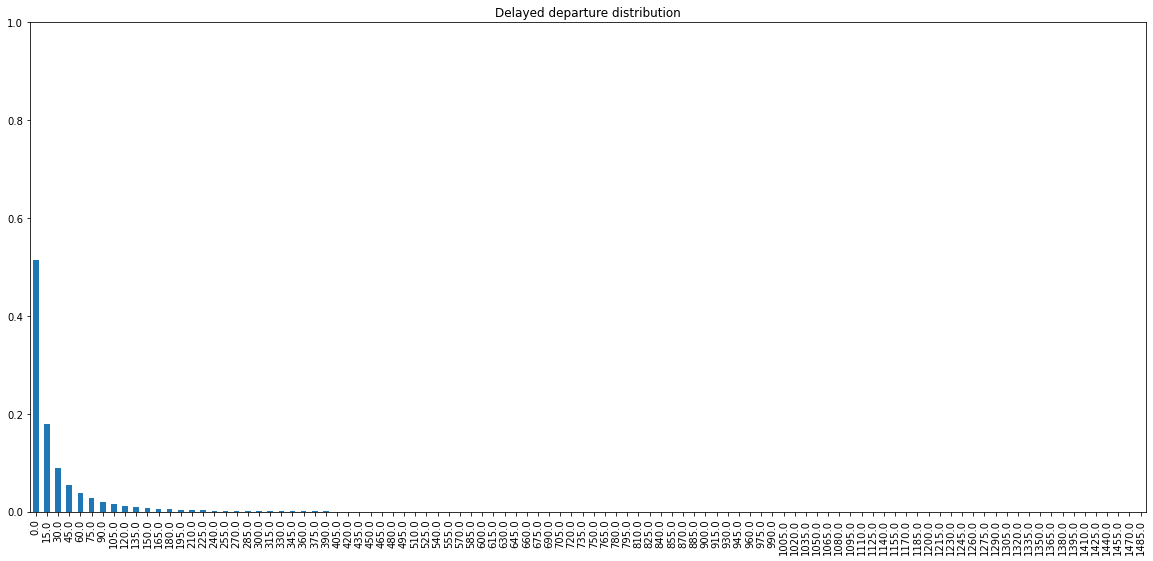

In [21]:
%%time
del_bins = np.array([i * 15 for i in range(0, n_bins)], dtype='float64')
delays_binned = delays.digitize(del_bins)
delays_binned.name = "delays"
delays_histogram = delays_binned.groupby('delays').count() / len(delays)
(
    delays_histogram
    .set_index(del_bins[delays_histogram.index.to_array()-1])
    .to_pandas()
    .sort_index()
    .plot(kind='bar', figsize=(20,9), ylim=[0,1.0], title='Delayed departure distribution')
)

CPU times: user 228 ms, sys: 0 ns, total: 228 ms
Wall time: 246 ms


<AxesSubplot:title={'center':'Early departure distribution'}>

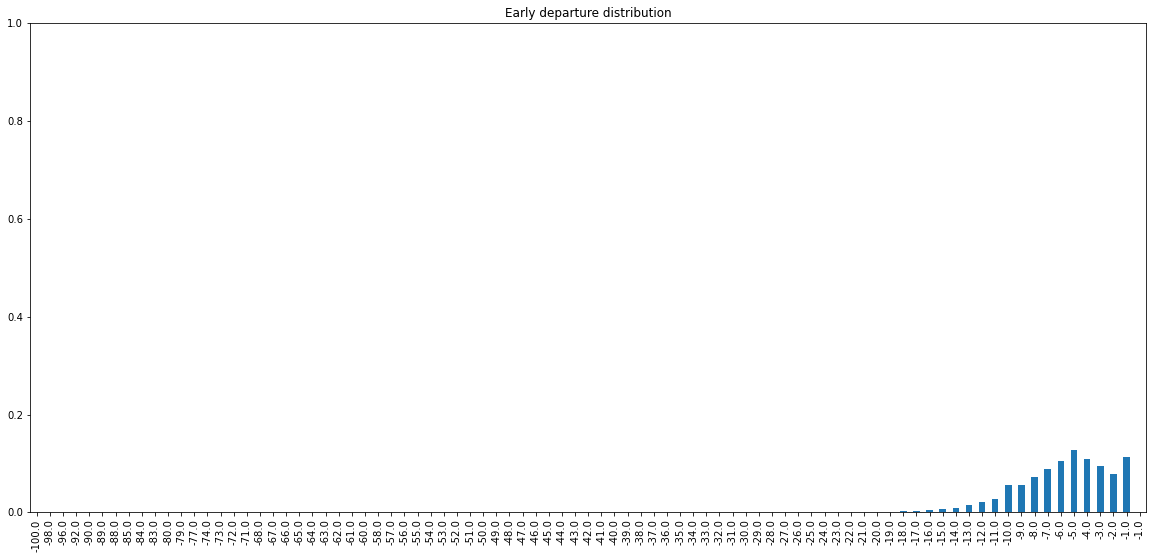

In [22]:
%%time
ontime_bins = np.array([i * (-1) for i in range(n_bins,0,-1)], dtype='float64')
ontime_binned = ontime.digitize(ontime_bins)
ontime_binned.name = "ontime"
ontime_histogram = ontime_binned.groupby("ontime").count() / len(ontime)
(
    ontime_histogram
    .set_index(ontime_bins[ontime_histogram.index.to_array()-1])
    .to_pandas()
    .sort_index()
    .plot(kind='bar', figsize=(20,9), ylim=[0,1.0], title='Early departure distribution')
)

### 3. Delays distribution over time 

In [23]:
q10 = lambda x: x.quantile(0.10); q10.__name__ = "q0.10"
q25 = lambda x: x.quantile(0.25); q25.__name__ = "q0.25"
q75 = lambda x: x.quantile(0.75); q75.__name__ = "q0.75"
q90 = lambda x: x.quantile(0.90); q90.__name__ = "q0.90"

delay_aggs = (
    flights[['MONTH', 'DEP_DELAY']]
    .groupby(by='MONTH')
    .agg({'DEP_DELAY': [q10, q25,'median',q75, q90]})
)

delay_aggs.columns = ['_'.join(col) for col in delay_aggs.columns]

In [24]:
host=delay_aggs.to_pandas()
host

,DEP_DELAY_q0.10,DEP_DELAY_q0.25,DEP_DELAY_median,DEP_DELAY_q0.75,DEP_DELAY_q0.90
MONTH,,,,,
1,-9.0,-6.0,-3.0,2.0,25.0
2,-9.0,-6.0,-3.0,2.0,28.0
3,-11.0,-8.0,-5.0,-1.0,13.0
4,-13.0,-10.0,-6.0,-4.0,0.0
5,-10.0,-8.0,-5.0,-2.0,2.0
6,-10.0,-7.0,-4.0,-1.0,6.0
7,-10.0,-7.0,-5.0,-2.0,7.0
8,-10.0,-7.0,-5.0,-2.0,6.0
9,-10.0,-7.0,-5.0,-2.0,5.0


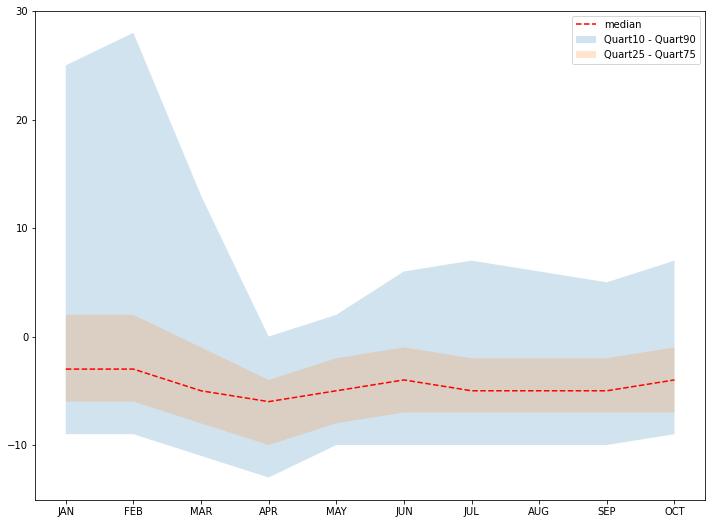

In [25]:
x = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(x, host['DEP_DELAY_median'], 'r--', label='median')
ax.fill_between(x, host['DEP_DELAY_q0.10'], host['DEP_DELAY_q0.90']
                , alpha=.2, label='Quart10 - Quart90')
ax.fill_between(x, host['DEP_DELAY_q0.25'], host['DEP_DELAY_q0.75']
                , alpha=.2, label='Quart25 - Quart75')
ax.legend();

### 4. What are the top 5 airlines and airports with ost delays and at least 1000 flights? What is the average delay?

In [26]:
delays = flights[flights['DEP_DELAY'] >  0][['DEP_DELAY', 'ORIGIN', 'DEST', 'OP_UNIQUE_CARRIER']]
ontime = flights[flights['DEP_DELAY'] <= 0][['DEP_DELAY', 'ORIGIN', 'DEST', 'OP_UNIQUE_CARRIER']]

In [27]:
bc.create_table('delays', delays)
bc.create_table('ontime', ontime)

In [28]:
%%time
## Origin delays
delayed_origin = bc.sql('''
    SELECT
        A.ORIGIN
        , B.Name AS ORIGIN_Airport
        , B.City AS ORIGIN_Country
        , B.Country AS ORIGIN_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS DELAY_CNT
        , AVG(A.DEP_DELAY) AS AVG_DELAY
    FROM delays AS A
    LEFT OUTER JOIN airports as B
        ON A.ORIGIN = B.IATA
    GROUP BY A.ORIGIN
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(A.DEP_DELAY) DESC
    LIMIT 60
''')
delayed_origin.head()

Steps Complete 0/15|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 984 ms, sys: 81 ms, total: 1.07 s
Wall time: 607 ms


,ORIGIN,ORIGIN_Airport,ORIGIN_Country,ORIGIN_Country0,Latitude,Longitude,DELAY_CNT,AVG_DELAY
0,MSN,Dane County Regional Truax Field,Madison,United States,43.139900,-89.337502,1099,64.316652
1,GSO,Piedmont Triad International Airport,Greensboro,United States,36.097801,-79.937302,1274,63.218210
2,SYR,Syracuse Hancock International Airport,Syracuse,United States,43.111198,-76.106300,1106,62.558770
3,TYS,McGhee Tyson Airport,Knoxville,United States,35.811001,-83.994003,1471,58.189667
4,CID,The Eastern Iowa Airport,Cedar Rapids,United States,41.884701,-91.710800,1069,55.180543


In [29]:
%%time
## Destination delays
delayed_destination = bc.sql('''
    SELECT A.DEST
        , B.Name AS DEST_Airport
        , B.City AS DEST_City
        , B.Country AS DEST_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS DELAY_CNT
        , AVG(DEP_DELAY) AS AVG_DELAY
    FROM delays AS A
    LEFT OUTER JOIN airports AS B
        ON A.DEST = B.IATA
    GROUP BY A.DEST
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 60
''')
delayed_destination.head()

Steps Complete 0/14|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 1.05 s, sys: 55.5 ms, total: 1.11 s
Wall time: 775 ms


,DEST,DEST_Airport,DEST_City,DEST_Country,Latitude,Longitude,DELAY_CNT,AVG_DELAY
0,ASE,Aspen-Pitkin Co/Sardy Field,Aspen,United States,39.223202,-106.869003,1035,69.315942
1,SFB,Orlando Sanford International Airport,Sanford,United States,28.777599,-81.237503,1684,60.046318
2,PIE,St Petersburg Clearwater International Airport,St. Petersburg,United States,27.910200,-82.687401,1174,57.097956
3,AVL,Asheville Regional Airport,Asheville,United States,35.436199,-82.541801,1015,54.154680
4,ORD,Chicago O'Hare International Airport,Chicago,United States,41.978600,-87.904800,29935,52.841089


In [30]:
%%time
# Airline
bc.sql('''
    SELECT A.OP_UNIQUE_CARRIER AS CARRIER
        , B.Name AS CARRIER_Name
        , B.Country AS CARRIER_Country
        , COUNT(*) AS DELAY_CNT
        , AVG(DEP_DELAY) AS AVG_DELAY
    FROM delays AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    GROUP BY A.OP_UNIQUE_CARRIER
        , B.Name
        , B.Country
    HAVING COUNT(*) > 1000
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 5
''')

Steps Complete 0/13|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 490 ms, sys: 28.5 ms, total: 519 ms
Wall time: 606 ms


,CARRIER,CARRIER_Name,CARRIER_Country,DELAY_CNT,AVG_DELAY
0,C5,CommutAir,United States,5031,65.337309
1,AX,Trans States Airlines,United States,3759,62.545358
2,ZW,Air Wisconsin,United States,6335,62.110339
3,G7,GoJet Airlines,United States,4812,55.846633
4,G7,Gandalf Airlines,Italy,4812,55.846633


### Most on time

In [31]:
%%time
ontime_origin = bc.sql('''
    SELECT A.ORIGIN
        , B.Name AS ORIGIN_Airport
        , B.City AS ORIGIN_City
        , B.Country AS ORIGIN_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS ONTIME_CNT
        , AVG(DEP_DELAY) AS AVG_ONTIME
    FROM ontime AS A
    LEFT OUTER JOIN airports AS B
        ON A.ORIGIN = B.IATA
    GROUP BY A.ORIGIN
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 60
''')
ontime_origin.head()

Steps Complete 0/14|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 1.81 s, sys: 10.2 ms, total: 1.82 s
Wall time: 1.65 s


,ORIGIN,ORIGIN_Airport,ORIGIN_City,ORIGIN_Country,Latitude,Longitude,ONTIME_CNT,AVG_ONTIME
0,DAL,Dallas Love Field,Dallas,United States,32.847099,-96.851799,30460,-3.738641
1,HOU,William P Hobby Airport,Houston,United States,29.645399,-95.278900,23884,-3.892397
2,MDW,Chicago Midway International Airport,Chicago,United States,41.785999,-87.752403,33359,-3.928415
3,ATL,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,158670,-4.086166
4,BWI,Baltimore/Washington International Thurgood Ma...,Baltimore,United States,39.175400,-76.668297,42744,-4.471505


In [32]:
%%time
ontime_destination = bc.sql('''
    SELECT A.DEST
        , B.Name AS DEST_Airport
        , B.City AS DEST_City
        , B.Country AS DEST_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS ONTIME_CNT
        , AVG(DEP_DELAY) AS AVG_ONTIME
    FROM ontime AS A
    LEFT OUTER JOIN airports AS B
        ON A.DEST = B.IATA
    GROUP BY A.DEST
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 30
''')
ontime_destination.head(5)

Steps Complete 0/14|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 1.04 s, sys: 56.7 ms, total: 1.1 s
Wall time: 872 ms


,DEST,DEST_Airport,DEST_City,DEST_Country,Latitude,Longitude,ONTIME_CNT,AVG_ONTIME
0,HOU,William P Hobby Airport,Houston,United States,29.645399,-95.278900,25486,-3.987993
1,DAL,Dallas Love Field,Dallas,United States,32.847099,-96.851799,32411,-3.991176
2,MDW,Chicago Midway International Airport,Chicago,United States,41.785999,-87.752403,36677,-4.009897
3,OAK,Metropolitan Oakland International Airport,Oakland,United States,37.721298,-122.221001,19387,-4.184402
4,ONT,Ontario International Airport,Ontario,United States,34.056000,-117.600998,9936,-4.450785


In [33]:
%%time
bc.sql('''
    SELECT A.OP_UNIQUE_CARRIER AS CARRIER
        , B.Name AS CARRIER_Name
        , B.Country AS CARRIER_Country
        , AVG(DEP_DELAY) AS AVG_ONTIME
    FROM ontime AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    GROUP BY A.OP_UNIQUE_CARRIER
        , B.Name
        , B.Country
    HAVING COUNT(*) > 1000
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 5
''')

Steps Complete 0/14|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 781 ms, sys: 53.4 ms, total: 835 ms
Wall time: 992 ms


,CARRIER,CARRIER_Name,CARRIER_Country,AVG_ONTIME
0,WN,Southwest Airlines,United States,-4.013290
1,DL,Delta Air Lines,United States,-4.773721
2,NK,Spirit Airlines,United States,-5.122735
3,QX,Horizon Air,United States,-5.478265
4,9E,Pinnacle Airlines,United States,-5.688819


### 5. What flights departing PHL experienced significant delay?

In [34]:
%%time
destinations = bc.sql('''
    SELECT ORIGIN
        , ORIGIN_LAT
        , ORIGIN_LON
        , DEST
        , DEST_LAT
        , DEST_LON
        , COUNT(*) AS DELAY_CNT
        , AVG(Delay) AS AVG_DELAY
    FROM (
        SELECT A.ORIGIN
            , B.Latitude AS ORIGIN_LAT
            , B.Longitude AS ORIGIN_LON
            , A.DEST
            , C.Latitude AS DEST_LAT
            , C.Longitude AS DEST_LON
            , A.DEP_DELAY AS Delay
        FROM flights AS A
        LEFT OUTER JOIN airports AS B
            ON A.ORIGIN = B.IATA
        LEFT OUTER JOIN airports AS C
            ON A.DEST = C.IATA
        WHERE ORIGIN = 'PHL'
            AND C.Country = 'United States'
            AND DEP_DELAY > 60  -- DELAYED BY MORE THAN HOUR
    ) AS A
    GROUP BY ORIGIN
        , ORIGIN_LAT
        , ORIGIN_LON
        , DEST
        , DEST_LAT
        , DEST_LON
    HAVING COUNT(*) > 50
    ORDER BY AVG_DELAY DESC
    LIMIT 30
''')
destinations.head(5)

Steps Complete 0/17|          |  0% (00:00 elapsed)

Total Batches Processed: 0

CPU times: user 511 ms, sys: 81.4 ms, total: 592 ms
Wall time: 369 ms


,ORIGIN,ORIGIN_LAT,ORIGIN_LON,DEST,DEST_LAT,DEST_LON,DELAY_CNT,AVG_DELAY
0,PHL,39.871899,-75.241096,DTW,42.212399,-83.353401,52,161.788462
1,PHL,39.871899,-75.241096,ORD,41.978600,-87.904800,61,160.409836
2,PHL,39.871899,-75.241096,MIA,25.793200,-80.290604,60,157.466667
3,PHL,39.871899,-75.241096,ORF,36.894600,-76.201202,64,153.515625
4,PHL,39.871899,-75.241096,DFW,32.896801,-97.038002,55,138.090909


### 6. Are there any spcific aircrafts (tail number) that are less reliable from PHL?

In [35]:
tail_numbers = bc.sql('''
    SELECT TAIL_NUM
        , B.Name AS AirlineName
        , DEP_DELAY
    FROM flights AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    WHERE TAIL_NUM <> ''
        AND DEP_DELAY > 0
        AND ORIGIN = 'PHL'
''')

Steps Complete 0/5|          |  0% (00:00 elapsed)

Total Batches Processed: 0

In [36]:
aircraft_aggs = (
    tail_numbers
    .groupby(by=['TAIL_NUM', 'AirlineName'])
    .agg({'DEP_DELAY': ['count', q25,'median',q75, 'max']})
)

aircraft_aggs.columns = ['_'.join(col) for col in aircraft_aggs.columns]
aircraft_aggs = (
    aircraft_aggs
    .query('DEP_DELAY_count > 10')
    .sort_values(by='DEP_DELAY_median', ascending=False)
)

In [37]:
aircraft_aggs.reset_index().head(10)

,TAIL_NUM,AirlineName,DEP_DELAY_count,DEP_DELAY_q0.25,DEP_DELAY_median,DEP_DELAY_q0.75,DEP_DELAY_max
0,N226JS,Comair,11,69.50,94.0,144.00,252.0
1,N122US,American Airlines,12,29.00,64.5,104.00,315.0
2,N669MB,Capital Cargo International Airlines,29,22.00,64.0,85.00,212.0
3,N669MB,Red Jet Andes,29,22.00,64.0,85.00,212.0
4,N669MB,West Air Sweden,29,22.00,64.0,85.00,212.0
5,N510AE,Comair,18,39.00,60.5,87.25,305.0
6,N137HQ,Midwest Airlines,12,19.00,55.5,85.75,165.0
7,N716PS,Comair,20,23.00,51.0,105.00,652.0
8,N965UW,American Airlines,18,8.25,49.5,97.00,149.0
9,N123HQ,Midwest Airlines,14,15.25,49.0,85.00,145.0


## COVID flights

In [38]:
bc.sql('''
    SELECT
        MAX(FL_DATE) AS max_date
        , MIN(FL_DATE) AS min_date
    from flights
''')

Steps Complete 0/3|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,max_date,min_date
0,2020-10-31,2020-01-01


In [39]:
delays_lt_mar20_share = bc.sql('''
    SELECT 
        SUM(Delayed) / CAST(COUNT(*) AS FLOAT) AS Delayed_share
    FROM (
        SELECT CASE WHEN DEP_DELAY > 0 THEN 1 ELSE 0 END AS Delayed
        FROM flights 
        WHERE FL_DATE < DATE'2020-03-01'
    ) AS A
'''
)

delays_gt_mar20_share = bc.sql('''
    SELECT 
        SUM(Delayed) / CAST(COUNT(*) AS FLOAT) AS Delayed_share
    FROM (
        SELECT CASE WHEN DEP_DELAY > 0 THEN 1 ELSE 0 END AS Delayed
        FROM flights 
        WHERE FL_DATE >= DATE'2020-03-01'
    ) AS A
'''
)

print(f'Before pandemic share of delayed flights: ' 
      f'{delays_lt_mar20_share["Delayed_share"][0]:.2%}')
print(f'After pandemic share of delayed flights: '
      f'{delays_gt_mar20_share["Delayed_share"][0]:.2%}')

Steps Complete 0/6|          |  0% (00:00 elapsed)

Total Batches Processed: 0

Steps Complete 0/6|          |  0% (00:00 elapsed)

Total Batches Processed: 0

Before pandemic share of delayed flights: 27.55%
After pandemic share of delayed flights: 13.87%


### Covid delay distributions

In [41]:
n_bins = 20
del_bins = np.array([i * 15 for i in range(0, n_bins)], dtype='float64')

# flights delayred before COVID-19 hit the US in Mar-20
delays_lt_mar20 = bc.sql('''
    SELECT
        DEP_DELAY
    FROM flights
    WHERE FL_DATE < DATE'2020-03-01'
    AND DEP_DELAY > 0
''')

delays_gt_mar20 = bc.sql('''
    SELECT
        DEP_DELAY
    FROM flights
    WHERE FL_DATE >= DATE'2020-03-01'
    AND DEP_DELAY > 0
''')


Steps Complete 0/2|          |  0% (00:00 elapsed)

Total Batches Processed: 0

Steps Complete 0/2|          |  0% (00:00 elapsed)

Total Batches Processed: 0

In [48]:
delays_binned_lt_mar20 = delays_lt_mar20['DEP_DELAY'].digitize(del_bins)
delays_binned_lt_mar20.name = 'bins_lt_mar20'
delays_hist_lt_mar20 = (
    delays_binned_lt_mar20.groupby('bins_lt_mar20').count() / len(delays_binned_lt_mar20)
)

In [49]:
delays_binned_gt_mar20 = delays_gt_mar20['DEP_DELAY'].digitize(del_bins)
delays_binned_gt_mar20.name = 'bins_gt_mar20'
delays_hist_gt_mar20 = (
    delays_binned_gt_mar20.groupby('bins_gt_mar20').count() / len(delays_binned_gt_mar20)
)

In [50]:
### Convert to Pandas for plotting

delays_hist_lt_mar20 = (
    delays_hist_lt_mar20
    .set_index(del_bins[delays_hist_lt_mar20.index.to_array()-1])
    .sort_index()
    .to_frame('Prior March 2020')
)

delays_hist_gt_mar20 = (
    delays_hist_gt_mar20
    .set_index(del_bins[delays_hist_gt_mar20.index.to_array()-1])
    .sort_index()
    .to_frame('After March 2020')
)

In [59]:
histograms = delays_hist_lt_mar20.join(delays_hist_gt_mar20).sort_index()

In [60]:
histograms

,Prior March 2020,After March 2020
0.0,0.487852,0.537971
15.0,0.182008,0.175350
30.0,0.093483,0.085918
45.0,0.059057,0.052244
60.0,0.039485,0.035555
75.0,0.028549,0.025921
90.0,0.021219,0.018590
105.0,0.016745,0.013840
120.0,0.012930,0.010299
135.0,0.010215,0.007902


In [62]:
histograms.describe().T

,count,mean,std,min,25%,50%,75%,max
Prior March 2020,20.0,0.05,0.111702,0.001595,0.003979,0.011248,0.031283,0.487852
After March 2020,20.0,0.05,0.122068,0.001173,0.002877,0.008973,0.028329,0.537971


In [63]:
from scipy import stats

stats.ttest_ind(
    delays_lt_mar20['DEP_DELAY'].to_pandas()
    , delays_gt_mar20['DEP_DELAY'].to_pandas()
    , equal_var = True
)

Ttest_indResult(statistic=31.584903072628936, pvalue=8.249340433962693e-219)

### Delays over time

In [64]:
delay_aggs = (
    flights[['YEAR','MONTH', 'DEP_DELAY']]
    .groupby(by=['YEAR','MONTH'])
    .agg({'DEP_DELAY': ['mean']})
)

delay_aggs.columns = ['_'.join(col) for col in delay_aggs.columns]

<AxesSubplot:xlabel='YEAR,MONTH'>

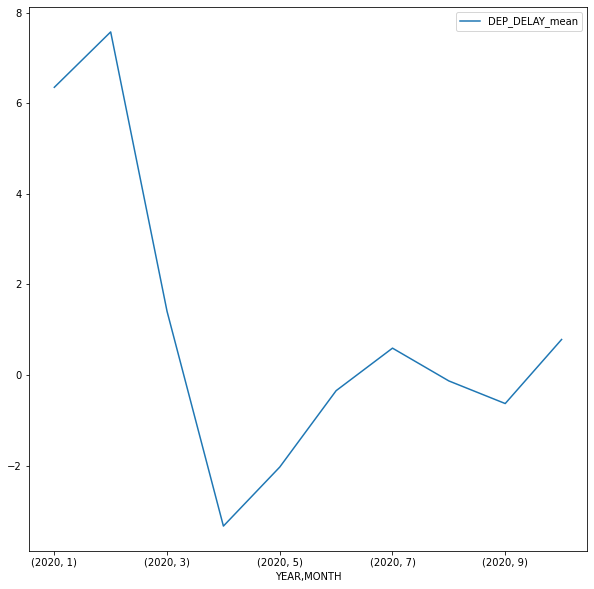

In [69]:
delay_aggs.to_pandas().sort_index().plot(figsize=(10,10))